# Classification 5

We will discuss ensemble methods, particularly for decision trees.

## Example: Spam classification

We will try out these three ensemble methods for spam classification (data [here](https://archive.ics.uci.edu/ml/datasets/Spambase)).

In [4]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [6]:
df = pd.read_csv('winequality-white.csv', sep=";")
df_temp = df.drop('quality', axis=1)
df_norm = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
q = df['quality'].apply(lambda x: 1 if x > 6 else 0)
df_norm = pd.concat((df_norm, q), 1)
print(df_norm)
df=df_norm.copy()

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.307692          0.186275     0.216867        0.308282   0.106825   
1          0.240385          0.215686     0.204819        0.015337   0.118694   
2          0.413462          0.196078     0.240964        0.096626   0.121662   
3          0.326923          0.147059     0.192771        0.121166   0.145401   
4          0.326923          0.147059     0.192771        0.121166   0.145401   
...             ...               ...          ...             ...        ...   
4893       0.230769          0.127451     0.174699        0.015337   0.089021   
4894       0.269231          0.235294     0.216867        0.113497   0.112760   
4895       0.259615          0.156863     0.114458        0.009202   0.094955   
4896       0.163462          0.205882     0.180723        0.007669   0.038576   
4897       0.211538          0.127451     0.228916        0.003067   0.032641   

      free sulfur dioxide  

In [7]:
df.iloc[0]

fixed acidity           0.307692
volatile acidity        0.186275
citric acid             0.216867
residual sugar          0.308282
chlorides               0.106825
free sulfur dioxide     0.149826
total sulfur dioxide    0.373550
density                 0.267785
pH                      0.254545
sulphates               0.267442
alcohol                 0.129032
quality                 0.000000
Name: 0, dtype: float64

### Create formula for design matrices

In [8]:
formula = 'quality ~ ' + ' + '.join(['Q("'+x+'")' \
                                    for x in df.columns.values\
                                    if x != 'quality'])
print(formula)

quality ~ Q("fixed acidity") + Q("volatile acidity") + Q("citric acid") + Q("residual sugar") + Q("chlorides") + Q("free sulfur dioxide") + Q("total sulfur dioxide") + Q("density") + Q("pH") + Q("sulphates") + Q("alcohol")


The **Q()** function stands for _quoting_, and is necessary when you have features like **char\_freq\_(**, in which the parenthesis throws off the _dmatrices()_ function. **Q("char\_freq\_(")** tells Python to consider the entire thing as a string.

## Create design matrices

In [9]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['quality'].values

## Create training and testing sets

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

## Set up all the classifiers

In [11]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=10,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=4,
                               random_state=1)

## Fit the models

In [12]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


## Accuracy scores

In [13]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

,Training Accuracy,Test Accuracy
Decision Tree,1.000000,0.808844
Bagging,0.989498,0.852381
Random Forest,0.990665,0.860544
Gradient Boosting,0.951284,0.847619


Text(0, 0.5, 'Variable Importance')

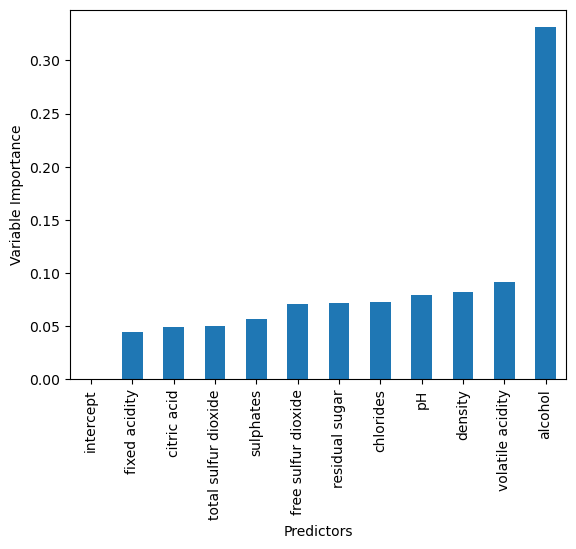

In [14]:
names =np.insert(df_norm.columns.values[0:11], 0, 'intercept')
#names
var_imp=pd.Series(models['Gradient Boosting'].feature_importances_,index=names)
var_imp.sort_values().plot(kind='bar')
xlabel('Predictors')
ylabel('Variable Importance')

All the classifiers (except perhaps Gradient Boosted Decision Trees) seem to overfit; their training accuracy is much higher than their test accuracy.

How does accuracy of gradient boosting depend on the number of trees and their depth?

Text(0, 0.5, 'Test accuracy')

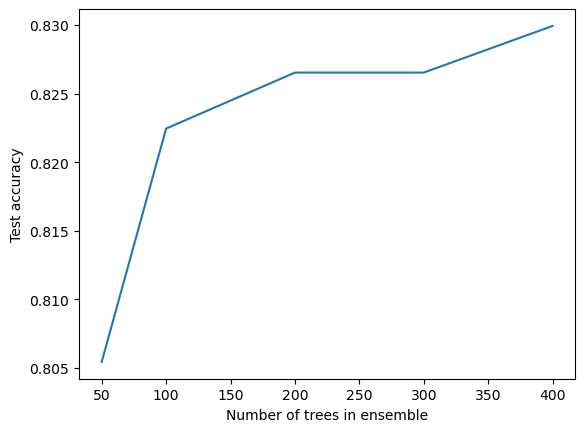

In [15]:
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=2,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')

200 trees seem to be enough.

How about the depth of the trees?

Text(0, 0.5, 'Test accuracy')

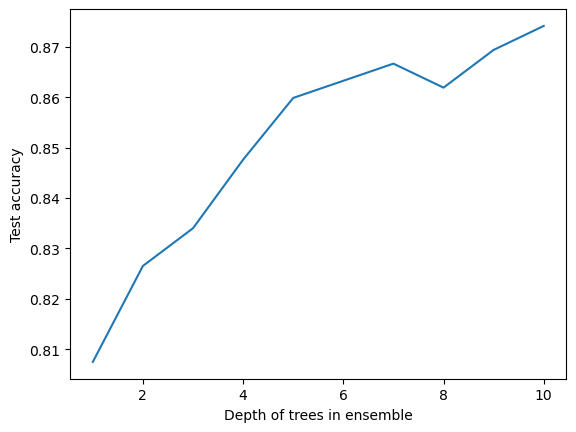

In [16]:
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')

Trees of depth 3 seem to be enough.

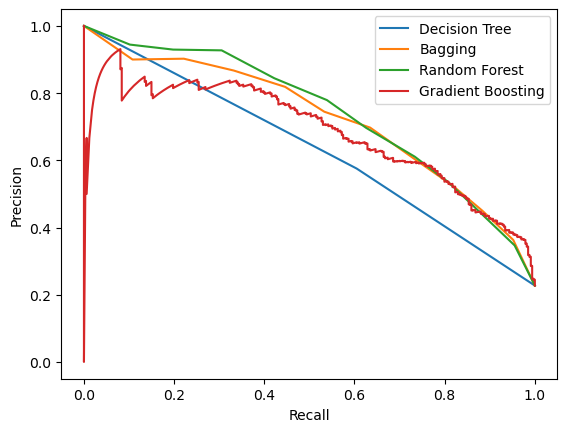

In [17]:
from sklearn.metrics import precision_recall_curve

for index, (name, model) in enumerate(models.items()):
    predictions = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, predictions[:, 1])
    plot(recall, precision, label=name)

xlabel('Recall')
ylabel('Precision')
legend(loc='best')
#savefig('Classification_5_data/precrec.png')